In [1]:
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt

In [2]:
# Camera Calibration
calib_file = 'camera_cal/'
calib_img = os.listdir(calib_file)

nx = 9
ny = 6

image_points = []
object_points = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for image_name in calib_img:
    
    image = cv2.imread(calib_file + image_name)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        image_points.append(corners)
        object_points.append(objp)

In [3]:
ret, mtx, dist, rvecs, tvects = cv2.calibrateCamera(object_points, image_points, gray.shape, None, None)

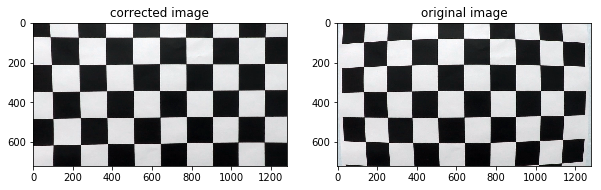

In [4]:
# undistort two example images:
img = cv2.imread(calib_file + calib_img[0])
dst = cv2.undistort(img, mtx, dist,None, mtx)

fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(dst)
axs[0].set_title('corrected image')
axs[1].imshow(img)
axs[1].set_title('original image')

In [5]:
# Select one of the images from the test images folder to start implementing advanced lane finding method
test_images_file = "test_images/"
test_images = os.listdir(test_images_file)

image_name = test_images_file + test_images[0]
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
# Undistord the selected test image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

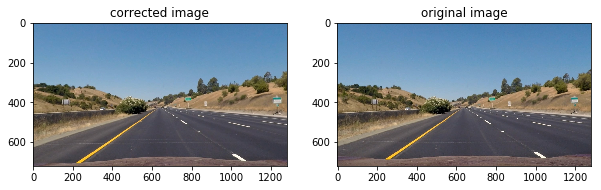

In [7]:
fig, axs  = plt.subplots(1,2, figsize = (10,4))
axs = axs.ravel()


axs[0].imshow(undist_image)
axs[0].set_title('corrected image')
axs[1].imshow(image)
axs[1].set_title('original image')

In [8]:
# Color Threshold on HLS(Hue, Lightness, saturation) images 
HLS_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2HLS)

H_channel = HLS_img[:,:,0]
L_channel = HLS_img[:,:,1]
S_channel = HLS_img[:,:,2]

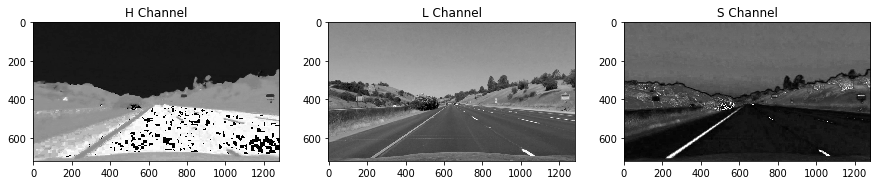

In [10]:
fig, axs = plt.subplots(1,3, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(H_channel, cmap = 'gray')
axs[0].set_title('H Channel')

axs[1].imshow(L_channel, cmap = 'gray')
axs[1].set_title("L Channel")

axs[2].imshow(S_channel, cmap = 'gray')
axs[2].set_title('S Channel')


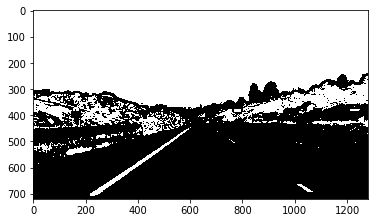

In [44]:
# Threshold the S channel
thresh = (70, 255)
S_binary = np.zeros_like(S_channel)
S_binary[(S_channel>thresh[0]) & (S_channel<=thresh[1])] = 1

plt.imshow(S_binary, cmap = 'gray')

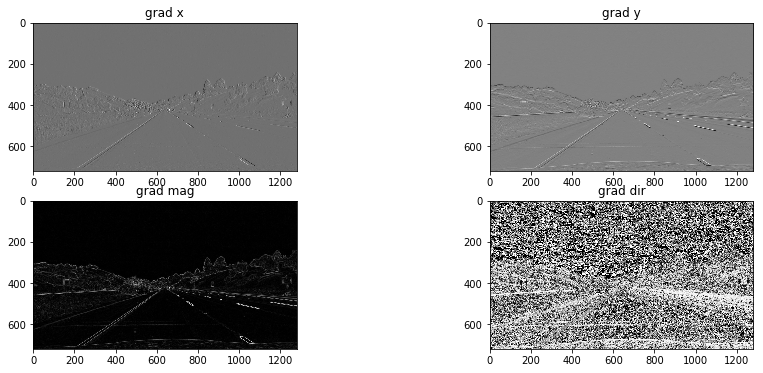

In [21]:
# Gradiend Threshold
gray_img = cv2.cvtColor(undist_image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

grad_mag = np.sqrt(grad_x**2 + grad_y**2)
grad_dir = np.arctan2(np.abs(grad_y),np.abs(grad_x))

fig, axs = plt.subplots(2,2, figsize = (15,6))
axs = axs.ravel()

axs[0].imshow(grad_x, cmap = 'gray')
axs[0]. set_title("grad x")

axs[1].imshow(grad_y, cmap = 'gray')
axs[1]. set_title("grad y")


axs[2].imshow(grad_mag, cmap = 'gray')
axs[2]. set_title("grad mag")

axs[3].imshow(grad_dir, cmap = 'gray')
axs[3]. set_title("grad dir")

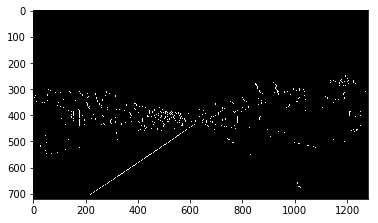

In [26]:
# Threshold the grad x
thresh = (90, 255)
binary_gradx = np.zeros_like(grad_x)
binary_gradx[(grad_x>= thresh[0]) & (grad_x<= thresh[1])] = 1

plt.imshow(binary_gradx, cmap= 'gray')

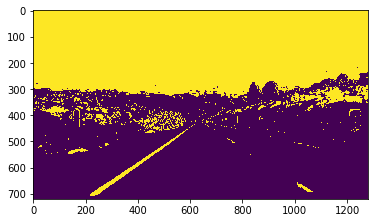

In [27]:
# Combine the Color Threshold and the gradient threshold
binary_img = np.zeros_like(S_binary)

binary_img[(S_binary ==1) | (binary_gradx ==1)] = 1

plt.imshow(binary_img)

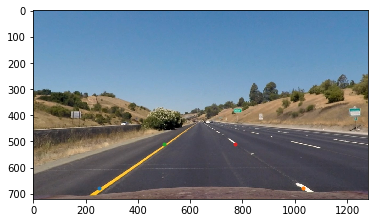

(720, 1280, 3)


In [32]:
# Use perespective transform to obtain a birds eye view of the road



plt.imshow(undist_image)
plt.plot(250, 680,'.')
plt.plot(1030, 680,'.')
plt.plot(500, 510,'.')
plt.plot(770,510,'.')
plt.show()


print(undist_image.shape)

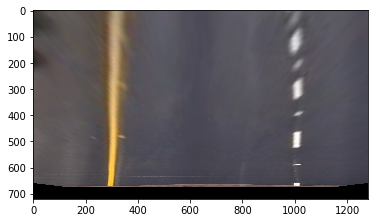

In [37]:
def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[308, 658],
                     [998, 658],
                     [532, 500],
                     [759,500]])
    
    dst = np.float32(
    [[308, 658],
     [998, 658],
     [325, 500],
     [998, 500]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

bird_eye = warp(undist_image)

plt.imshow(bird_eye)

In [144]:
def HLS_threshold (img, thresh):
    HLS_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    S_channel = HLS_img[:,:,2]
    
    S_binary = np.zeros_like(S_channel)
    S_binary[(S_channel >= thresh[0]) & (S_channel <= thresh[1])] = 1
    return S_binary

In [145]:
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if orient == 'x':
        grad = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    else:
        grad = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
        
    grad_binary = np.zeros_like(gray_img)
    
    grad_binary[(grad > thresh[0]) & (grad <= thresh[1])] = 1
    
    return grad_binary

In [146]:
def mag_thresh(img, sobel_kernel = 3, thresh = (0, 255)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_mag = (255*grad_mag/np.max(grad_mag))
    
    mag_binary = np.zeros_like(gray_img)
    mag_binary[(grad_mag > thresh[0]) & (grad_mag <= thresh[1])] = 1
    
    return mag_binary

In [147]:
def dir_thresh(img, sobel_kernel = 3, thresh = (-np.pi/2, np.pi/2)):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    grad_x = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    
    
    grad_dir = np.arctan2(np.abs(grad_y), np.abs(grad_x))
    
    dir_binary = np.zeros_like(gray_img)
    dir_binary[(grad_dir > thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [148]:
def grad_thresh(img, thresh_x, thresh_y, thresh_m, thresh_d):
    
    gradx = abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, thresh = thresh_x)
    grady = abs_sobel_thresh(img, orient = 'y', sobel_kernel = 3, thresh = thresh_y)
    mag_binary = mag_thresh(img, sobel_kernel = 3, thresh = thresh_m)
    dir_binary = dir_thresh(img, sobel_kernel = 3, thresh = thresh_d)
    
    combined_binary = np.zeros_like(gradx)
    
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary

In [149]:
def combine_thresholds(binary_1, binary_2):
    final_binary = np.zeros_like(binary_1)
    
    final_binary[(binary_1 == 1) | (binary_2 == 1)] = 1
    
    return final_binary

In [150]:
def image_process(img):
    
    corrected_img  = undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    Color_binary = HLS_threshold(img, (150, 255))
    Grad_binary = gradient_threshold(img, (150, 255))
    
    combined_binary = combine_thresh(Color_binary, Grad_binary)
    
    result = warp(combined_binary)
  
    
    return result

In [183]:
my_image = cv2.imread(image_name)
new_image = grad_thresh(my_image, (30, 255), (30, 255), (30, 255), (-np.pi/2, np.pi/2))

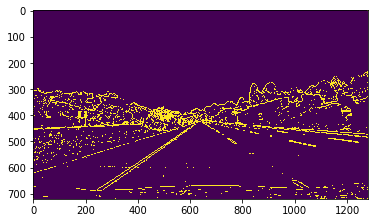

In [184]:
plt.imshow(new_image)